In [11]:
import pandas as pd
from sentence_transformers import SentenceTransformer  
#NB: Ti potrebbe servire avere pyTorch installato.
import umap        #necessario per dimensionality reduction
import hdbscan     #necessario per clustering
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: '@rpath/libjpeg.8.dylib'
  Referenced from: '/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so'
  Reason: tried: '/opt/anaconda3/lib/python3.9/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/anaconda3/lib/python3.9/site-packages/torchvision/../../../libjpeg.8.dylib' (no such file), '/opt/anaconda3/lib/python3.9/lib-dynload/../../libjpeg.8.dylib' (no such file), '/opt/anaconda3/bin/../lib/libjpeg.8.dylib' (no such file), '/usr/local/lib/libjpeg.8.dylib' (no such file), '/usr/lib/libjpeg.8.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")


In [12]:
url = 'https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv'
data_raw = pd.read_csv(url)   

print(data_raw.columns)

# Creare una lista con tutti i testi dei tweet
data = list(data_raw['TweetText']) 

Index(['Topic', 'Sentiment', 'TweetId', 'TweetDate', 'TweetText'], dtype='object')


In [13]:
model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
embeddings = model.encode(data, show_progress_bar=True)

/opt/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/160 [00:00<?, ?it/s]

In [14]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)


In [15]:

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

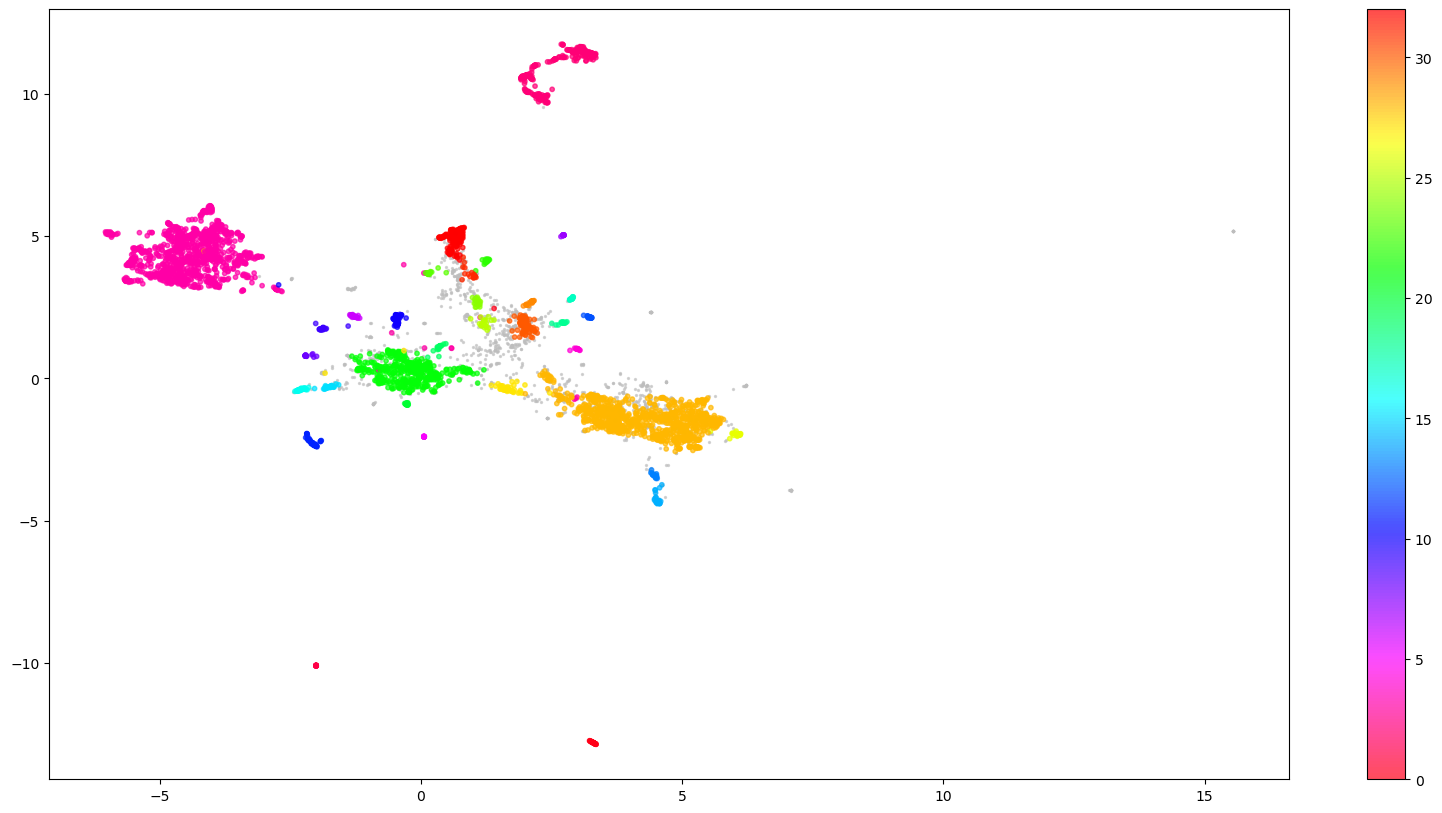

In [16]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=2, alpha=0.6, label='Outliers')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, alpha=0.7, cmap='hsv_r', label='Clustered')
# Aggiungi la barra del colore
plt.colorbar()

In [17]:
#create df

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))


In [18]:
#uniamo i documenti aventi lo stesso topic
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

#definiamo la funzione c_tf_idf:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
#procediamo!
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [19]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()  # Modificato qui
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes.head(15)


,Topic,Size
4,3,1161
0,-1,1072
29,28,954
22,21,476
3,2,311
33,32,185
31,30,111
12,11,66
15,14,59
11,10,56


In [20]:
top_n_words[0][:10]

[('skype', 0.5191470987279297),
 ('sitio', 0.25628315598295415),
 ('oficial', 0.24982214161524607),
 ('lanza', 0.24596751735772304),
 ('microsoft', 0.14076599547480445),
 ('http', 0.07279978929833271),
 ('bolivia', 0.054313352601546634),
 ('skydrive', 0.054313352601546634),
 ('parte', 0.04925388413030616),
 ('desde', 0.043069228215071094)]